In [ ]:
!pip install kaggle

In [ ]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

print("¡API key de Kaggle configurada!")

¡API key de Kaggle configurada!


In [ ]:
!kaggle datasets download -d davilsena/ckdataset

!unzip ckdataset.zip

!ls

Dataset URL: https://www.kaggle.com/datasets/davilsena/ckdataset
License(s): CC0-1.0
  0% 0.00/2.48M [00:00<?, ?B/s]
100% 2.48M/2.48M [00:00<00:00, 1.03GB/s]
Archive:  ckdataset.zip
  inflating: ckextended.csv          
ckdataset.zip  ckextended.csv  sample_data


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os


IMG_HEIGHT = 48
IMG_WIDTH = 48
NUM_CLASSES = 8
def load_and_prepare_data(csv_path):
    """
    Carga el CSV, parsea los píxeles, normaliza y separa los datos.
    """
    print(f"Cargando datos desde {csv_path}...")
    df = pd.read_csv(csv_path)


    def parse_pixels(pixel_string):
        return np.array([int(x) for x in pixel_string.split(' ')])

    df['pixels'] = df['pixels'].apply(parse_pixels)


    X = np.array(df['pixels'].tolist())


    X = X / 255.0

    X = X.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)


    y = df['emotion']

    y = to_categorical(y, num_classes=NUM_CLASSES)

    train_mask = (df['Usage'] == 'Training')
    val_mask = (df['Usage'] == 'PublicTest')
    test_mask = (df['Usage'] == 'PrivateTest')

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    print(f"Datos de Entrenamiento: {X_train.shape[0]} muestras")
    print(f"Datos de Validación:   {X_val.shape[0]} muestras")
    print(f"Datos de Prueba:        {X_test.shape[0]} muestras")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


csv_path = '/content/ckextended.csv'
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_prepare_data(csv_path)

# Verificar las formas de los arrays
print(f"\nShape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")

Cargando datos desde /content/ckextended.csv...
Datos de Entrenamiento: 734 muestras
Datos de Validación:   91 muestras
Datos de Prueba:        95 muestras

Shape X_train: (734, 48, 48, 1)
Shape y_train: (734, 8)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


NEUTRAL_CLASS_INDEX = 6


y_train_indices = np.argmax(y_train, axis=1)


mask_neutral = (y_train_indices == NEUTRAL_CLASS_INDEX)
mask_minority = (y_train_indices != NEUTRAL_CLASS_INDEX)


X_train_neutral = X_train[mask_neutral]
y_train_neutral = y_train[mask_neutral]


X_train_minority = X_train[mask_minority]
y_train_minority = y_train[mask_minority]

print(f"Total de entrenamiento: {len(X_train)}")
print(f"Muestras de 'Neutral':    {len(X_train_neutral)}")
print(f"Muestras 'Minoritarias': {len(X_train_minority)}")

Total de entrenamiento: 734
Muestras de 'Neutral':    474
Muestras 'Minoritarias': 260


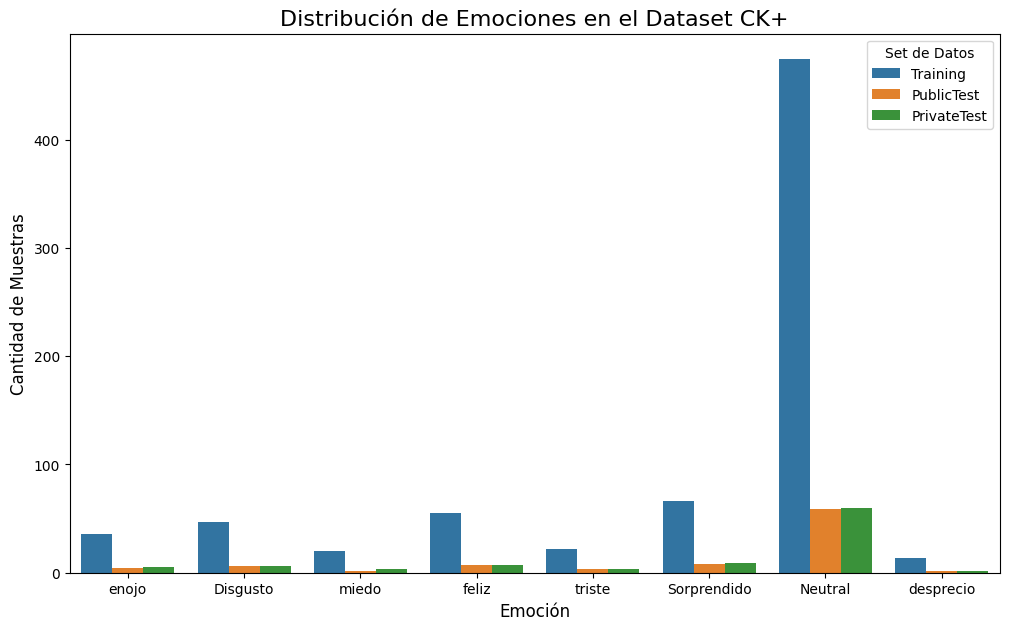

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


emotion_map = {
    0: 'enojo', 1: 'Disgusto', 2: 'miedo', 3: 'feliz',
    4: 'triste', 5: 'Sorprendido', 6: 'Neutral', 7: 'desprecio'
}


csv_path = '/content/ckextended.csv'
try:
    df_viz = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {csv_path}")
    print("Asegúrate de que la ruta sea correcta.")
    df_viz = None

if df_viz is not None:
    df_viz['emotion_label'] = df_viz['emotion'].map(emotion_map)

    label_order = [emotion_map[i] for i in range(len(emotion_map))]

    plt.figure(figsize=(12, 7))
    sns.countplot(
        data=df_viz,
        x='emotion_label',
        order=label_order,
        hue='Usage'
    )
    plt.title('Distribución de Emociones en el Dataset CK+', fontsize=16)
    plt.xlabel('Emoción', fontsize=12)
    plt.ylabel('Cantidad de Muestras', fontsize=12)
    plt.legend(title='Set de Datos')
    plt.show()



Mostrando 12 ejemplos del set de prueba (PrivateTest)...
Total de imágenes en prueba: 95


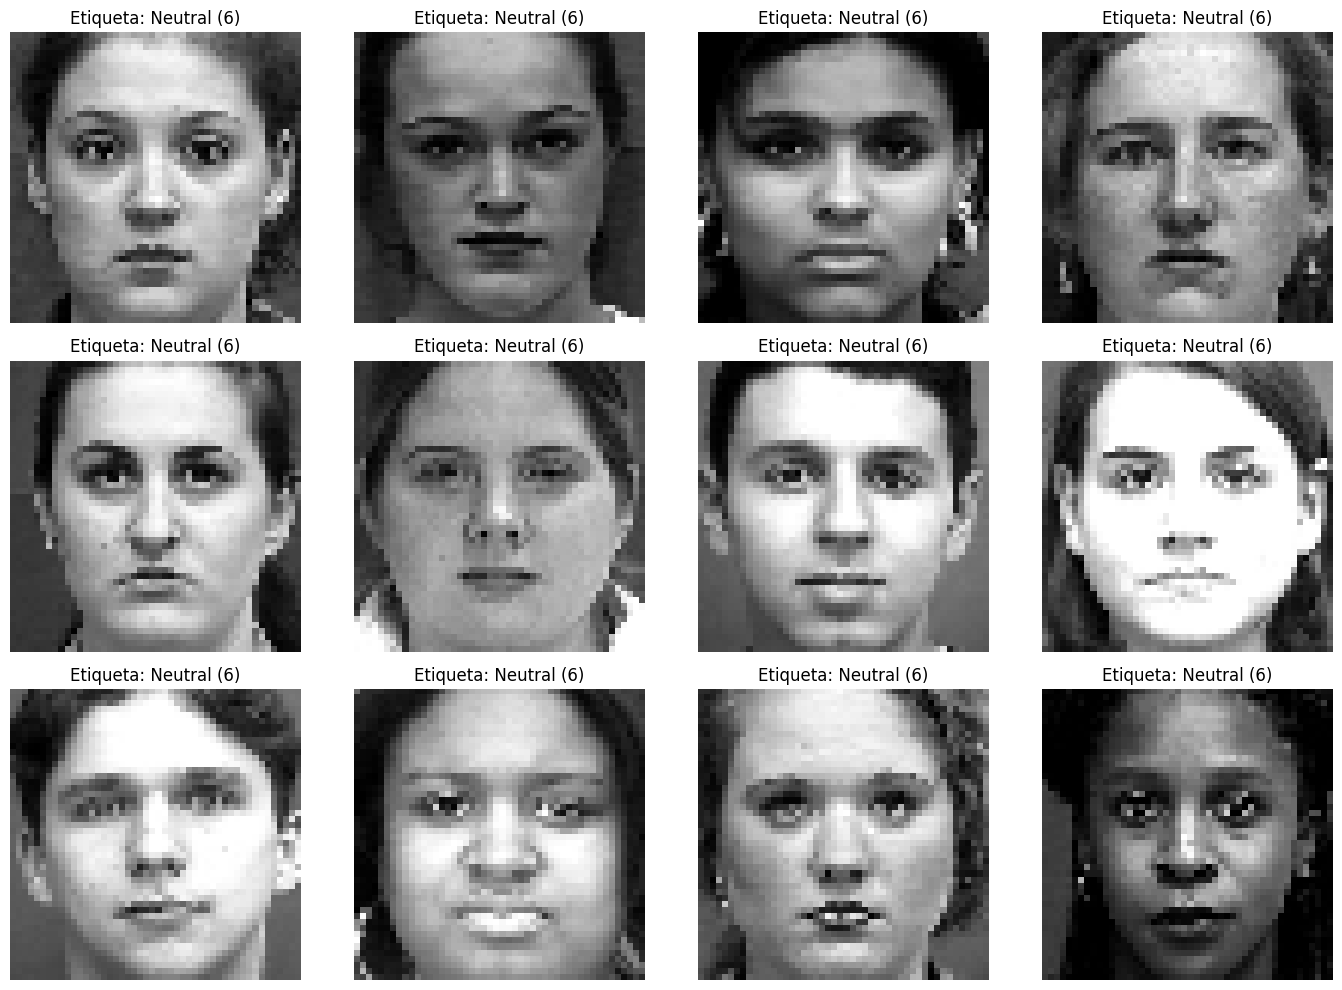

In [ ]:


print(f"\nMostrando 12 ejemplos del set de prueba (PrivateTest)...")
print(f"Total de imágenes en prueba: {len(X_test)}")

# --- Configuración de la cuadrícula ---
num_rows = 3
num_cols = 4
num_images = num_rows * num_cols

# Asegurarse de no intentar mostrar más imágenes de las que hay
num_images = min(num_images, len(X_test))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))

# Aplanar los ejes si solo hay una fila/columna para iterar fácilmente
axes = axes.flatten()

for i in range(num_images):
    # Obtener la imagen
    # X_test tiene shape (N, 48, 48, 1), imshow necesita (48, 48)
    img = X_test[i].reshape(IMG_HEIGHT, IMG_WIDTH)

    # Obtener la etiqueta
    # y_test es one-hot (ej. [0,0,1,0...]), necesitamos el índice (ej. 2)
    label_index = np.argmax(y_test[i])
    label_name = emotion_map[label_index]


    ax = axes[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Etiqueta: {label_name} ({label_index})", fontsize=12)
    ax.axis('off') # Ocultar ejes (x, y)

# Ocultar ejes sobrantes si los hay
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:

datagen_aug = ImageDataGenerator(
    rotation_range=20,      # Rotar imágenes aleatoriamente (grados)
    width_shift_range=0.1,  # Mover horizontalmente
    height_shift_range=0.1, # Mover verticalmente
    zoom_range=0.1,         # Zoom aleatorio
    horizontal_flip=True    # Voltear horizontalmente
)

datagen_no_aug = ImageDataGenerator(
    rotation_range=20,      # Rotar imágenes aleatoriamente (grados)
    width_shift_range=0.1,  # Mover horizontalmente
    height_shift_range=0.1, # Mover verticalmente
    zoom_range=0.1,         # Zoom aleatorio
    horizontal_flip=True    # Voltear horizontalmente) # No hace nada
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_model(input_shape, num_classes):
    model = Sequential(name="Emotion_CNN")


    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape,kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))


    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))


    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

   # model.add(Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01)))
   # model.add(BatchNormalization())
    #model.add(MaxPooling2D((2, 2)))


    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(num_classes, activation='softmax'))
    return model


input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
model = create_model(input_shape, NUM_CLASSES)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Emotion_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,064 (2.61 MB)

 Trainable params: 684,360 (2.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
BATCH_SIZE_MINORITY =16
BATCH_SIZE_NEUTRAL = 16
TOTAL_BATCH_SIZE = BATCH_SIZE_MINORITY + BATCH_SIZE_NEUTRAL

flow_minority = datagen_aug.flow(
    X_train_minority, y_train_minority,
    batch_size=BATCH_SIZE_MINORITY,
    shuffle=True
)

flow_neutral = datagen_no_aug.flow(
    X_train_neutral, y_train_neutral,
    batch_size=BATCH_SIZE_NEUTRAL,
    shuffle=True
)

# Función del generador combinado
def combined_generator(gen_minority, gen_neutral):
    while True:
        # Obtener el siguiente lote de cada generador
        x_minor, y_minor = next(gen_minority)
        x_neutral, y_neutral = next(gen_neutral)

        # Combinarlos en un solo lote
        x_combined = np.concatenate((x_minor, x_neutral), axis=0)
        y_combined = np.concatenate((y_minor, y_neutral), axis=0)

        # Mezclar el lote combinado final
        indices = np.arange(x_combined.shape[0])
        np.random.shuffle(indices)
        x_combined = x_combined[indices]
        y_combined = y_combined[indices]

        # Entregar el lote combinado
        yield (x_combined, y_combined)


train_generator = combined_generator(flow_minority, flow_neutral)

print(f"\nGenerador combinado creado.")
print(f"Lote total (Batch Size): {TOTAL_BATCH_SIZE}")


Generador combinado creado.
Lote total (Batch Size): 32


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


STEPS_PER_EPOCH = len(X_train) // TOTAL_BATCH_SIZE
EPOCHS = 100
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


model_checkpoint = ModelCheckpoint(
    filepath='mejor_modelo.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


callbacks_list = [early_stopping, model_checkpoint]


print("\nIniciando entrenamiento ")



history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list
)




print("\nCargando el mejor modelo guardado (mejor_modelo.keras)...")
best_model = tf.keras.models.load_model('mejor_modelo.keras')

print("\nEvaluando el MEJOR modelo con datos de prueba...")
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"\nPrecisión en Prueba (Test Accuracy) del MEJOR modelo: {test_acc * 100:.2f}%")


Iniciando entrenamiento 
Epoch 1/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.1375 - loss: 4.4748
Epoch 1: val_accuracy improved from -inf to 0.07692, saving model to mejor_modelo.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.1398 - loss: 4.4707 - val_accuracy: 0.0769 - val_loss: 3.4870
Epoch 2/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1726 - loss: 4.2080
Epoch 2: val_accuracy did not improve from 0.07692
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.1744 - loss: 4.1899 - val_accuracy: 0.0659 - val_loss: 3.4843
Epoch 3/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2352 - loss: 4.0005
Epoch 3: val_accuracy did not improve from 0.07692
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2359 - loss: 3.9893 - val_accuracy: 0.0220 - val_loss: 3.4909
Epoch 4/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2078 - loss: 3.7679
Epoch 4: val_accuracy did not improve from 0.07692
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/s

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

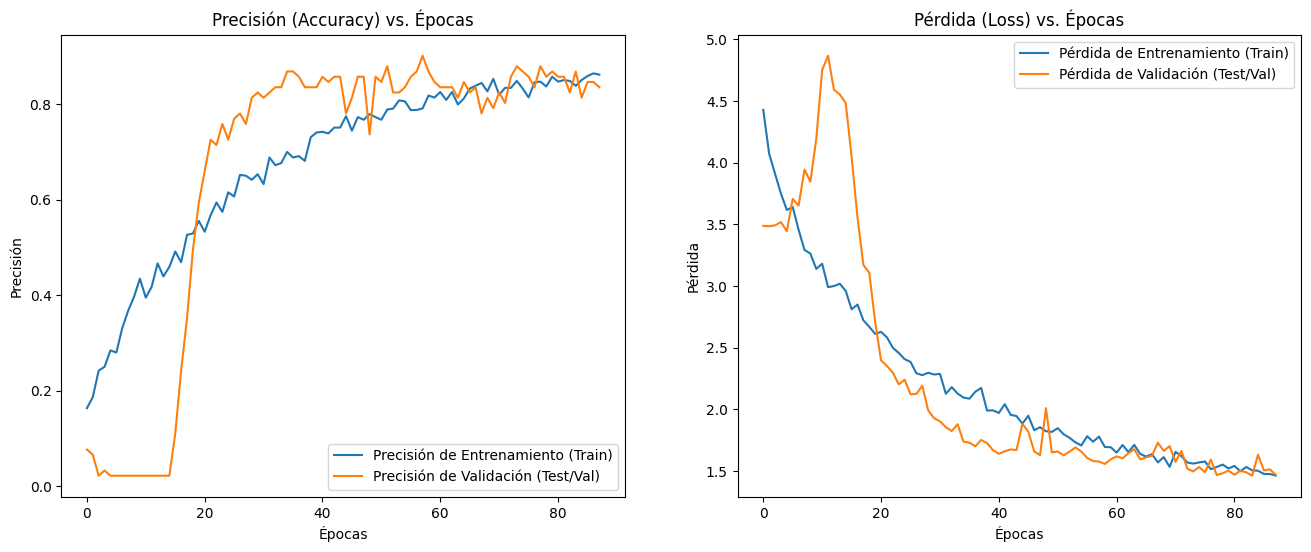

In [ ]:
import matplotlib.pyplot as plt


if 'history' not in locals():
    print("Error: La variable 'history' no existe.")
    print("Asegúrate de haber ejecutado 'model.fit()' primero.")
else:

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))


    plt.figure(figsize=(16, 6))

    # Gráfico de Precisión (Accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión de Entrenamiento (Train)')
    plt.plot(epochs_range, val_acc, label='Precisión de Validación (Test/Val)')
    plt.legend(loc='lower right')
    plt.title('Precisión (Accuracy) vs. Épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')

    #Gráfico de Pérdida (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento (Train)')
    plt.plot(epochs_range, val_loss, label='Pérdida de Validación (Test/Val)')
    plt.legend(loc='upper right')
    plt.title('Pérdida (Loss) vs. Épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')

    plt.show()

Modelo cargado exitosamente desde mejor_modelo.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step

--- Probando imagen #45 ---
Predicción:     feliz (3)
Etiqueta Real:  Neutral (6)


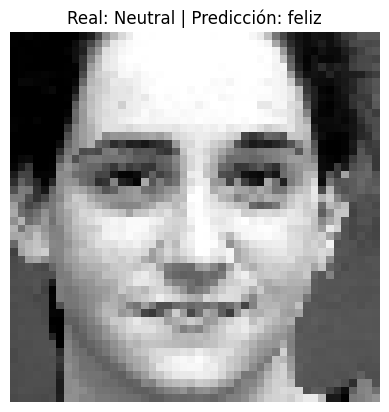

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Definir el mapa de emociones (asegúrate de que exista) ---
emotion_map = {
    0: 'enojo', 1: 'Disgusto', 2: 'miedo', 3: 'feliz',
    4: 'triste', 5: 'Sorprendido', 6: 'Neutral', 7: 'desprecio'
}

# --- 2. Cargar tu modelo guardado ---
# ¡IMPORTANTE! Asegúrate de que este nombre coincida con tu archivo
model_path = 'mejor_modelo.keras'

try:
    # Carga la arquitectura, los pesos y la configuración de compilación
    loaded_model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado exitosamente desde {model_path}")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    print("Asegúrate de que el nombre del archivo sea correcto.")

# --- 3. Tomar una imagen de prueba ---
# Puedes cambiar este índice para probar diferentes imágenes
test_image_index = 45

test_image = X_test[test_image_index]
true_label_index = np.argmax(y_test[test_image_index])
true_label_name = emotion_map[true_label_index]

# --- 4. Pre-procesar la imagen para predecir ---
# model.predict() espera un "lote" (batch) de imágenes.
# Debemos cambiar la forma de (48, 48, 1) a (1, 48, 48, 1)
image_for_prediction = np.expand_dims(test_image, axis=0)

# --- 5. Realizar la predicción ---
prediction = loaded_model.predict(image_for_prediction)

# 'prediction' es un array de 8 probabilidades, ej:
# [[0.01, 0.02, 0.1, 0.8, 0.02, 0.03, 0.01, 0.01]]

predicted_index = np.argmax(prediction)
predicted_label_name = emotion_map[predicted_index]

# --- 6. Mostrar el resultado ---
print(f"\n--- Probando imagen #{test_image_index} ---")
print(f"Predicción:     {predicted_label_name} ({predicted_index})")
print(f"Etiqueta Real:  {true_label_name} ({true_label_index})")

# Mostrar la imagen
plt.imshow(test_image.reshape(48, 48), cmap='gray')
plt.title(f"Real: {true_label_name} | Predicción: {predicted_label_name}")
plt.axis('off')
plt.show()

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2025-11-25 23:56:51--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.007s  

2025-11-25 23:56:51 (129 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
%pip install opencv-python
%pip install tensorflow opencv-python numpy

In [ ]:
import tensorflow as tf
import os

# 1. Configuración de rutas
model_path = 'mejor_modelo.keras'
tflite_save_path = 'modelo_quantizado.tflite'

try:
    # 2. Cargar el modelo Keras original
    print(f"Cargando modelo desde: {model_path}")
    model = tf.keras.models.load_model(model_path)

    # 3. Crear el Convertidor (Converter)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Esto le dice a TensorFlow: "Comprime los pesos lo más posible"
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # 5. Realizar la conversión
    print("Convirtiendo y comprimiendo...")
    tflite_model = converter.convert()

    # 6. Guardar el archivo .tflite
    with open(tflite_save_path, 'wb') as f:
        f.write(tflite_model)

    print(f"\n¡Éxito! Modelo guardado en: {tflite_save_path}")

    # 7. Comparar tamaños para ver la ganancia
    size_keras = os.path.getsize(model_path) / (1024 * 1024)
    size_tflite = os.path.getsize(tflite_save_path) / (1024 * 1024)

    print(f"Tamaño Original (.keras):  {size_keras:.2f} MB")
    print(f"Tamaño Comprimido (.tflite): {size_tflite:.2f} MB")
    print(f"Reducción: {((size_keras - size_tflite) / size_keras) * 100:.1f}%")

except Exception as e:
    print(f"Error durante la conversión: {e}")

Cargando modelo desde: mejor_modelo.keras
Convirtiendo y comprimiendo...
Saved artifact at '/tmp/tmp7e1acp_z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  132164474823760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132164474821648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132164474821456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132164474820880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132164474819152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132164474822608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132164474821840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132164474822224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132164474820304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13216447482068

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Resizing, RandomFlip, RandomRotation, RandomZoom, RandomContrast, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import os

IMG_HEIGHT = 48
IMG_WIDTH = 48
NUM_CLASSES = 8
BATCH_SIZE = 64

In [ ]:
def load_and_prepare_data(csv_path):
    print(f"Cargando datos desde {csv_path}...")
    df = pd.read_csv(csv_path)


    def parse_pixels(pixel_string):
        return np.array([int(x) for x in pixel_string.split(' ')])

    df['pixels'] = df['pixels'].apply(parse_pixels)

    X = np.array(df['pixels'].tolist())
    X = X / 255.0
    X = X.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)


    y = df['emotion']
    y = to_categorical(y, num_classes=NUM_CLASSES)

    train_mask = (df['Usage'] == 'Training')
    val_mask = (df['Usage'] == 'PublicTest')
    test_mask = (df['Usage'] == 'PrivateTest')

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    print(f"Entrenamiento: {X_train.shape}")
    print(f"Validación:    {X_val.shape}")
    print(f"Prueba:        {X_test.shape}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

csv_path = '/content/ckextended.csv'
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_prepare_data(csv_path)

Cargando datos desde /content/ckextended.csv...
Entrenamiento: (734, 48, 48, 1)
Validación:    (91, 48, 48, 1)
Prueba:        (95, 48, 48, 1)


In [ ]:
def build_resnet_emotion_model(input_shape=(48, 48, 1), num_classes=8):
    input_tensor = Input(shape=input_shape)

    x = RandomFlip("horizontal")(input_tensor)
    x = RandomRotation(0.1)(x)
    x = RandomZoom(0.1)(x)
    x = RandomContrast(0.1)(x)


    # ResNet necesita 224x224 y 3 canales
    x = Resizing(224, 224)(x)
    x = Concatenate()([x, x, x])


    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)

    # Congelamos la base para el primer entrenamiento
    base_model.trainable = False

    # CABEZA DE CLASIFICACIÓN
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_resnet_emotion_model(num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 48, 48, 1) │          0 │ input_layer_1[0]… │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 48, 48, 1) │          0 │ random_flip[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 48, 48, 1) │          0 │ random_rotation[… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 48, 48, 1) │          0 │ random_zoom[0][0] │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 224, 224,  │          0 │ random_contrast[… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ resizing[0][0],   │
│ (Concatenate)       │ 3)                │            │ resizing[0][0],   │
│                     │                   │            │ resizing[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ concatenate[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 25,694,088 (98.02 MB)

 Trainable params: 2,106,376 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_resnet_emotion.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


print("Iniciando entrenamiento...")
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Iniciando entrenamiento...
Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.4485 - loss: 1.9455
Epoch 1: val_accuracy improved from -inf to 0.64835, saving model to best_resnet_emotion.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 719ms/step - accuracy: 0.4573 - loss: 1.9282 - val_accuracy: 0.6484 - val_loss: 1.3878 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6060 - loss: 1.4205
Epoch 2: val_accuracy did not improve from 0.64835
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.6073 - loss: 1.4218 - val_accuracy: 0.6484 - val_loss: 1.3272 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6075 - loss: 1.4837
Epoch 3: val_accuracy did not improve from 0.64835
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - accuracy: 0.6099 - loss: 1.4774 - val_accuracy: 0.6484 - val_loss: 1.3193 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6519 - loss: 1.3670
Epoch 4

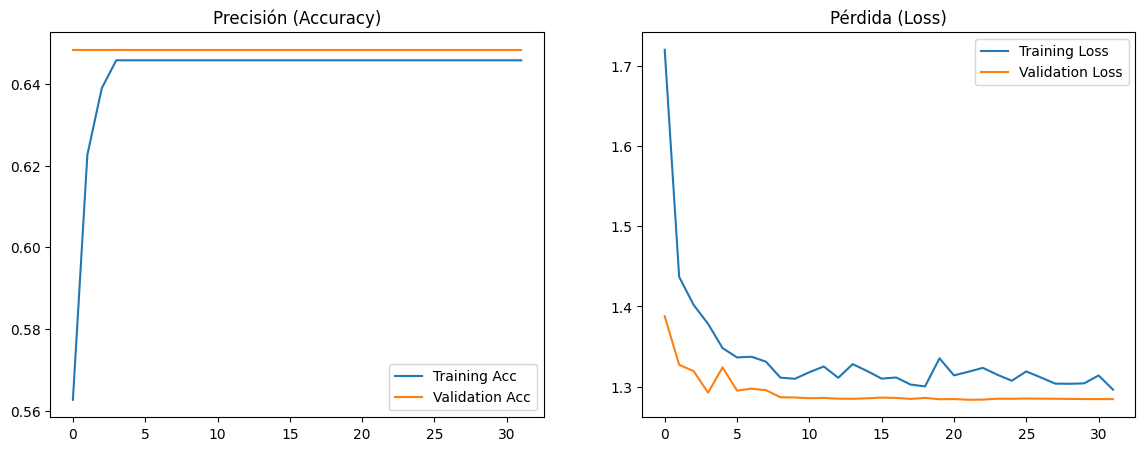

In [ ]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Acc')
    plt.plot(epochs, val_acc, label='Validation Acc')
    plt.title('Precisión (Accuracy)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Pérdida (Loss)')
    plt.legend()
    plt.show()

plot_results(history)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Resizing, Concatenate, GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_mobilenet_emotion_model(input_shape=(48, 48, 1), num_classes=8):
    input_tensor = Input(shape=input_shape)

    x = RandomFlip("horizontal")(input_tensor)
    x = RandomRotation(0.1)(x)
    x = RandomZoom(0.1)(x)


    x = Resizing(96, 96)(x)

    # Convertir a 3 canales (RGB) copiando la escala de grises
    x = Concatenate()([x, x, x])

    # --- 3. BASE MOBILENET V2 ---
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)

    # Congelamos la base para el calentamiento (warm-up)
    base_model.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x) # Dropout medio para regularizar
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Instanciar
model_mobilenet = build_mobilenet_emotion_model(num_classes=NUM_CLASSES)
model_mobilenet.summary()

/tmp/ipython-input-386715188.py:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)


Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_3       │ (None, 48, 48, 1) │          0 │ input_layer_5[0]… │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_2   │ (None, 48, 48, 1) │          0 │ random_flip_3[0]… │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_2       │ (None, 48, 48, 1) │          0 │ random_rotation_… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_4          │ (None, 96, 96, 1) │          0 │ random_zoom_2[0]… │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96, 96, 3) │          0 │ resizing_4[0][0], │
│ (Concatenate)       │                   │            │ resizing_4[0][0], │
│                     │                   │            │ resizing_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ concatenate_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compilar
model_mobilenet.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Entrenar (Fase 1)
print("--- FASE 1: Entrenamiento de la cabeza (Base congelada) ---")
history_mb = model_mobilenet.fit(
    X_train, y_train,
    epochs=20, # Pocas épocas, solo para calentar
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

--- FASE 1: Entrenamiento de la cabeza (Base congelada) ---
Epoch 1/20
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4973 - loss: 2.6075
Epoch 1: val_accuracy did not improve from 0.75824
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.5022 - loss: 2.5317 - val_accuracy: 0.6813 - val_loss: 1.2732 - learning_rate: 0.0010
Epoch 2/20
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6654 - loss: 1.2198
Epoch 2: val_accuracy did not improve from 0.75824
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6656 - loss: 1.2188 - val_accuracy: 0.7143 - val_loss: 1.0808 - learning_rate: 0.0010
Epoch 3/20
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7131 - loss: 1.1015
Epoch 3: val_accuracy did not improve from 0.75824
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7130 - loss: 1.0934 - val_accuracy: 0.7473 - val_loss: 1.0323 - learning_rate: 0.0010
Epoch 4/20
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7169 - loss: 0.9887
Epoch 4: val_accuracy did n

In [ ]:
# 1. Descongelar
model_mobilenet.trainable = True

# Opcional: Si quieres ser conservador, congela las primeras 100 capas y entrena el resto
# (MobileNetV2 tiene unas 155 capas)
for layer in model_mobilenet.layers[:-50]:
    layer.trainable = False

print("Base descongelada. Iniciando ajuste fino...")

# 2. Re-compilar con Learning Rate BAJO
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-5), # 0.00001
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# 3. Entrenar (Fase 2)
print("--- FASE 2: Fine-Tuning ---")
history_mb_fine = model_mobilenet.fit(
    X_train, y_train,
    epochs=30, # Dale tiempo para ajustarse
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Base descongelada. Iniciando ajuste fino...
--- FASE 2: Fine-Tuning ---
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7970 - loss: 0.6705
Epoch 1: val_accuracy did not improve from 0.78022
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7962 - loss: 0.6730 - val_accuracy: 0.7802 - val_loss: 0.8074 - learning_rate: 1.0000e-05
Epoch 2/30
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7949 - loss: 0.6775
Epoch 2: val_accuracy did not improve from 0.78022
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7937 - loss: 0.6814 - val_accuracy: 0.7582 - val_loss: 0.8162 - learning_rate: 1.0000e-05
Epoch 3/30
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7805 - loss: 0.7400
Epoch 3: val_accuracy did not improve from 0.78022
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7789 - loss: 0.7456 - val_accuracy: 0.7582 - val_loss: 0.8175 - learning_rate: 1.0000e-05
Epoch 4/30
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7847 - loss: 0.7382
Epo

In [ ]:
# Evaluar en el conjunto de test
loss, accuracy = model_mobilenet.evaluate(X_test, y_test, verbose=0)

print(f"--- RESULTADOS FINAL EN TEST ---")
print(f"Pérdida (Loss): {loss:.4f}")
print(f"Precisión (Accuracy): {accuracy*100:.2f}%")

--- RESULTADOS FINAL EN TEST ---
Pérdida (Loss): 0.8179
Precisión (Accuracy): 77.89%


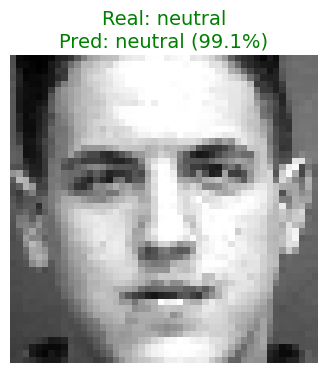

Probabilidades por clase:
Enojo: 0.34%
Desprecio: 0.13%
miedo: 0.12%
feliz: 0.01%
triste: 0.20%
sorprendido: 0.03%
neutral: 99.15%
desprecio: 0.02%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class_names = ['Enojo', 'disguto', 'miedo', 'feliz', 'triste', 'sorprendido', 'neutral', 'desprecio']

def predecir_aleatoria():

    idx = np.random.randint(0, len(X_test))


    imagen = X_test[idx]
    label_real_idx = np.argmax(y_test[idx])
    label_real = class_names[label_real_idx]

    prediccion = model_mobilenet.predict(np.expand_dims(imagen, axis=0), verbose=0)


    label_pred_idx = np.argmax(prediccion)
    label_pred = class_names[label_pred_idx]
    confianza = np.max(prediccion) * 100

    plt.figure(figsize=(4, 4))
    plt.imshow(imagen.squeeze(), cmap='gray')


    color = 'green' if label_real_idx == label_pred_idx else 'red'

    plt.title(f"Real: {label_real}\nPred: {label_pred} ({confianza:.1f}%)", color=color, fontsize=14)
    plt.axis('off')
    plt.show()


    print("Probabilidades por clase:")
    for i, prob in enumerate(prediccion[0]):
        print(f"{class_names[i]}: {prob*100:.2f}%")

# Ejecutar la función
predecir_aleatoria()

Generando predicciones masivas...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


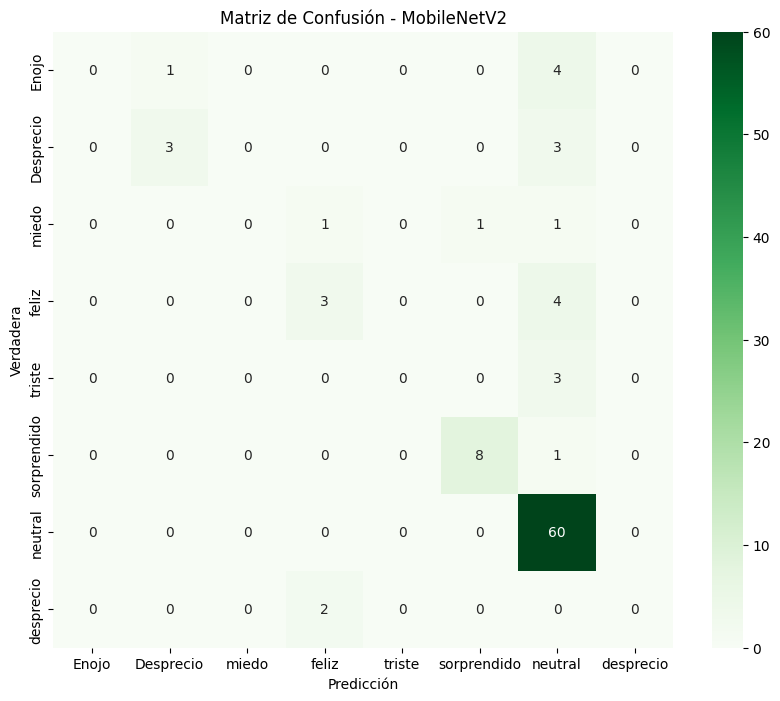

              precision    recall  f1-score   support

       Enojo       0.00      0.00      0.00         5
   Desprecio       0.75      0.50      0.60         6
       miedo       0.00      0.00      0.00         3
       feliz       0.50      0.43      0.46         7
      triste       0.00      0.00      0.00         3
 sorprendido       0.89      0.89      0.89         9
     neutral       0.79      1.00      0.88        60
   desprecio       0.00      0.00      0.00         2

    accuracy                           0.78        95
   macro avg       0.37      0.35      0.35        95
weighted avg       0.67      0.78      0.71        95



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Generando predicciones masivas...")
y_pred_probs = model_mobilenet.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - MobileNetV2')
plt.ylabel('Verdadera')
plt.xlabel('Predicción')
plt.show()


print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [ ]:
model_mobilenet.save('mobilenet_emociones_final.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.
